# Analisis Perilaku Pengguna Dating Apps : Gender, Swipe Right Ratio, dan Likes

Notebook ini merangkum hasil analisis eksplorasi data terkait perilaku pengguna aplikasi
dating apps berdasarkan gender. Analisis berfokus pada demografi pengguna:

1. Demografi golongan pendapatan pengguna
2. Perbedaan **Swipe Right Ratio** antar **Gender**.
3. Jumlah **Likes Received** berdasarkan **Gender**.
4. Hubungan antara **App Usage Time(minutes)** dengan **Likes Receive**.
5. Persebaran **Sexual Orientation** berdasar **Gender** dan analisa Chi square untuk melihat korelasinya.

Dataset berasal dari "Dating App Behavior Dataset 2025" yang berasal dari Kaggle, lalu dimasukan kedalam database MySQL bernama 'DatingSQL' dengan total ~50 ribu baris data.


# Import dan Load Data

Pada bagian ini akan digunakan untuk mengimpor semua library dan juga memberikan ringkasan statistik tahap awal.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

# Import fungsi dari utils & script EDA
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.db_connection import *
from utils.cleaning import *

# Load data
df_query = load_query('* FROM user_data')
pd.set_option('display.max_colwidth', 12)
pd.set_option('display.precision', 2)
df_query.head()


c:\Users\user\Downloads\DataRole\DSPy\utils\db_connection.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM user_data", conn)


,gender,sexual_orientation,location_type,income_bracket,education_level,interest_tags,app_usage_time_min,app_usage_time_label,swipe_right_ratio,swipe_right_label,likes_received,mutual_matches,profile_pics_count,bio_length,message_sent_count,emoji_usage_rate,last_active_hour,swipe_time_of_day,match_outcome
0,Prefer N...,Gay,Urban,High,Bachelor’s,"Fitness,...",52,Moderate,0.60,Optimistic,173,23,4,44,75,0.36,13,Early Mo...,Mutual M...
1,Male,Bisexual,Suburban,Upper-Mi...,No Forma...,Language...,279,Extreme ...,0.56,Optimistic,107,7,3,301,35,0.42,0,Morning,Chat Ign...
2,Non-binary,Pansexual,Suburban,Low,Master’s,"Movies, ...",49,Moderate,0.41,Optimistic,91,27,2,309,33,0.41,1,After Mi...,Date Hap...
3,Genderfluid,Gay,Metro,Very Low,Postdoc,"Coding, ...",185,Extreme ...,0.32,Balanced,147,6,5,35,5,0.07,21,Morning,No Action
4,Male,Bisexual,Urban,Middle,Bachelor’s,Clubbing...,83,High,0.32,Balanced,94,11,1,343,34,0.11,22,After Mi...,One-side...


In [2]:
print("Deskripsi singkat statistik dari dataset:\n")
df_query.describe(include='all')

Deskripsi singkat statistik dari dataset:



,gender,sexual_orientation,location_type,income_bracket,education_level,interest_tags,app_usage_time_min,app_usage_time_label,swipe_right_ratio,swipe_right_label,likes_received,mutual_matches,profile_pics_count,bio_length,message_sent_count,emoji_usage_rate,last_active_hour,swipe_time_of_day,match_outcome
count,50000,50000,50000,50000,50000,50000,50000.00,50000,50000.00,50000,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000,50000
unique,6,8,6,7,9,40206,NaN,7,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10
top,Female,Straight,Remote Area,High,Bachelor’s,"Fitness,...",NaN,Extreme ...,NaN,Optimistic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,After Mi...,One-side...
freq,8384,6326,8519,7309,5646,6,NaN,20140,NaN,26873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8524,5112
mean,NaN,NaN,NaN,NaN,NaN,NaN,149.91,NaN,0.50,NaN,99.53,13.87,2.99,250.17,50.07,0.29,11.52,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,86.99,NaN,0.20,NaN,58.00,9.11,2.00,144.80,29.17,0.16,6.92,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,74.00,NaN,0.37,NaN,49.00,6.00,1.00,125.00,25.00,0.16,5.00,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,150.00,NaN,0.50,NaN,100.00,13.00,3.00,250.00,50.00,0.27,12.00,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,225.00,NaN,0.64,NaN,150.00,22.00,5.00,376.00,75.00,0.39,18.00,NaN,NaN


**Jumlah Baris yang ada duplikat**

In [3]:
print("Jumlah baris duplikat:", df_query.duplicated().sum())

Jumlah baris duplikat: 0


# Analisis perilaku yang berkaitan dengan gender
**Crosstab gender dan Uji Chi Square pada korelasi gender dan income bracket**

Analisis ini dibuat dengan tujuan untuk :
1. Mencari apakah terdapat ketimpangan pada golongan pendapatan tiap gender?
2. Melihat secara kasar demografi golongan pendapatan pengguna aplikasi pada tiap gendernya.

c:\Users\user\Downloads\DataRole\DSPy\utils\db_connection.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


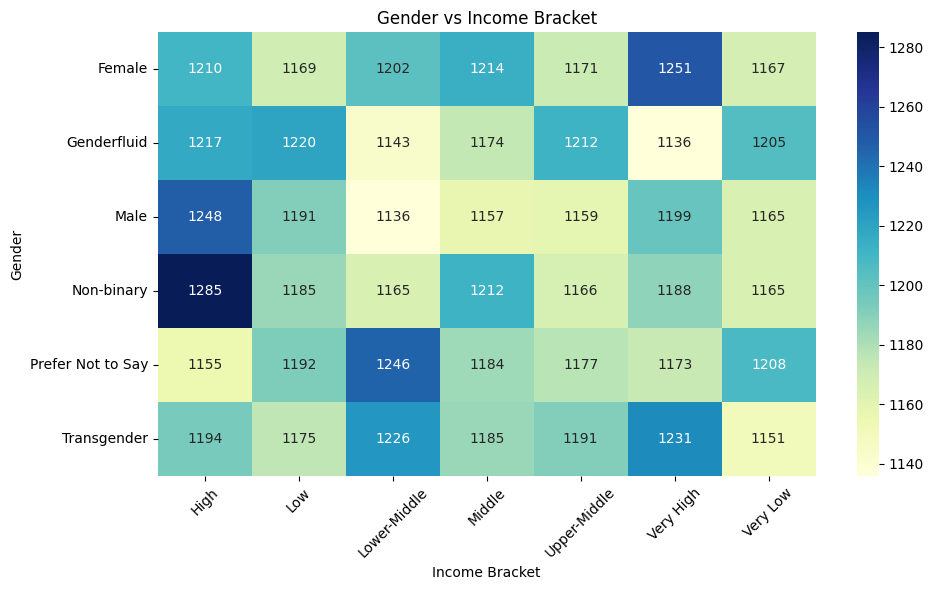

Hasil uji Chi-Square 

Chi-square statistic: 29.965629424169624
P-value: 0.46741510221829086


In [4]:
eda_income = load_columns(['gender', 'income_bracket']) #gunakan list untuk load beberapa collumns
eda_income['gender'] = eda_income['gender'].apply(clean_gender) # memanggil fungsi untuk membersihkan kolom data
eda_income['income_bracket'] = eda_income['income_bracket'].apply(clean_Income)# memanggil fungsi untuk membersihkan kolom data
cross_tab = pd.crosstab(eda_income['gender'], eda_income['income_bracket'])
#print(cross_tab)
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Gender vs Income Bracket")
plt.xlabel("Income Bracket")
plt.ylabel("Gender")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Lakukan uji chi-square
chi2, p, dof, expected = chi2_contingency(cross_tab)
print ("Hasil uji Chi-Square \n")
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

# Insight yang didapat setelah analisa

1. Tidak terdapat ketimpangan pendapatan yang mencolok terjadi antar gender (Hal ini dapat ditunjukkan dengan hasil uji chi square dengan p-values sebesar 0.46 yang menunjukkan data bersifat independen satu sama lain)
2. Tingkat pendapatan high merupakan tingkat pendapatan yang memiliki frequensi kemunculan paling banyak dibanding tingkat pendapatan lain
3. Meskipun secara statistik independen, namun puncak modus yang didapat pada tiap-tiap gender menunjukkan perbedaan. seperti pada contoh Gender : Female,Non-Binary dan juga Transgender dengan puncak modus berada di golongan Very-High(1251,1285 dan 1231 pada tiap gender), hal ini kontras dengan Gender prefer not to say dengan puncak modus berada di Lower-Middle.
4. Lalu dapat dilihat juga frekuensi terendah dari keseluruhan table berada di gender Male dengan frekuensi 1136 yang berada di golongan Lower-Middle.
5. Terdapat kategori yang kurang umum : Secara umum, kategori "Very Low" dan "Upper-Middle" memiliki warna yang cenderung lebih terang (kuning/hijau muda), menunjukkan bahwa ini adalah kelompok pendapatan yang frekuensinya paling sedikit di antara pengguna aplikasi secara keseluruhan.

# Analisa swipe right ratio antar gender

**Tujuan dari dilakukannya analisa ini adalah** :

1. Apakah ada kecerendungan suatu gender yang mendapat lebih rasio swipe right lebih banyak daripada yang lain?, dan melihat pola distribusinya



=== Rata-rata Swipe Right Ratio per Gender ===
gender
Prefer Not to Say    0.5
Male                 0.5
Female               0.5
Transgender          0.5
Genderfluid          0.5
Non-binary           0.5
Name: swipe_right_ratio, dtype: float64

=== Hasil Uji ANOVA ===
F-statistic: 0.330
P-value    : 0.89539
→ Tidak terdapat perbedaan signifikan,antar gender


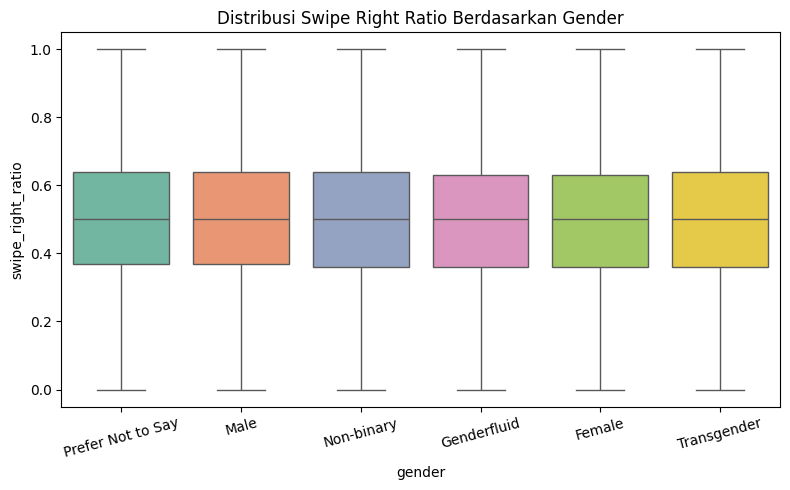

In [5]:
def analyze_swipe_ratio(df_query):
    df_query = df_query.dropna(subset=['gender'])
    df_query = clean_numeric(df_query, 'swipe_right_ratio')

    print("\n=== Rata-rata Swipe Right Ratio per Gender ===")
    mean_table = df_query.groupby('gender')['swipe_right_ratio'].mean().sort_values(ascending=False)
    print(mean_table)

    # Uji ANOVA
    groups = [group['swipe_right_ratio'] for _, group in df_query.groupby('gender')]
    stat, p = f_oneway(*groups)
    print("\n=== Hasil Uji ANOVA ===")
    print(f"F-statistic: {stat:.3f}")
    print(f"P-value    : {p:.5f}")
    print("→ Terdapat perbedaan signifikan." if p < 0.05 else "→ Tidak terdapat perbedaan signifikan,antar gender")

    # Visualisasi boxplot
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_query, x='gender', y='swipe_right_ratio', hue='gender', palette='Set2', legend=False)
    plt.title('Distribusi Swipe Right Ratio Berdasarkan Gender')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
analyze_swipe_ratio(df_query)

# Insight Swipe Right Ratio vs Gender

1. Berdasarkan uji ANOVA, tidak ada perbedaan rata-rata swipe right ratio yang signifikan secara statistik di antara berbagai gender (p=0.89, yang jauh lebih besar dari α=0.05). Ini mengindikasikan bahwa rata-rata swipe right ratio dari semua kelompok gender pada dasarnya sama.
 
2. Visualisasi boxplot menunjukkan bahwa median swipe right ratio untuk semua gender berada di sekitar 0.50. Artinya, untuk setiap gender, sekitar 50% penggunanya memiliki rasio di bawah 0.50, dan 50% lainnya di atas 0.50. Secara visual, distribusi data untuk setiap gender terlihat serupa dan tidak condong ke sisi mana pun (tidak skewed).

# Analisis Gender vs Likes Received

**Tujuan dilakukannya analisis ini adalah**

1. Melihat distribusi like yang diterima tiap gender
2. Melihat distribusi pada frekuensi mana di tiap gender mendapat like yang paling banyak. 


=== Rata-rata Likes Received per Gender ===
gender
Transgender          100.61
Non-binary            99.68
Genderfluid           99.63
Female                99.53
Male                  98.91
Prefer Not to Say     98.78
Name: likes_received, dtype: float64

===  Likes Received per Gender counts ===
gender
Female               8384
Non-binary           8366
Transgender          8353
Prefer Not to Say    8335
Genderfluid          8307
Male                 8255
Name: likes_received, dtype: int64


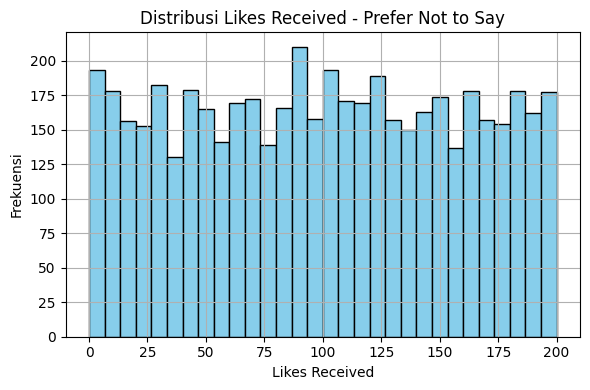

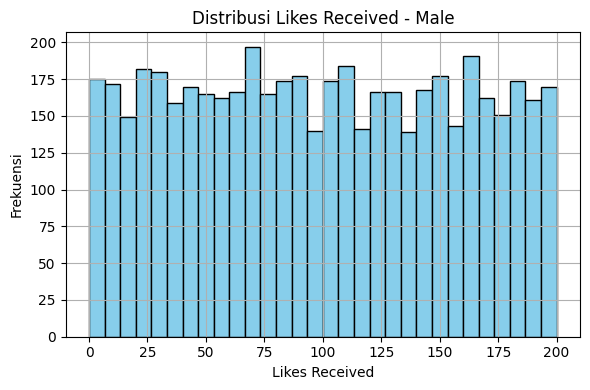

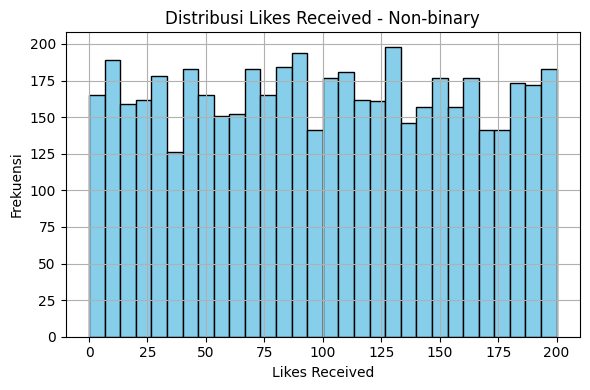

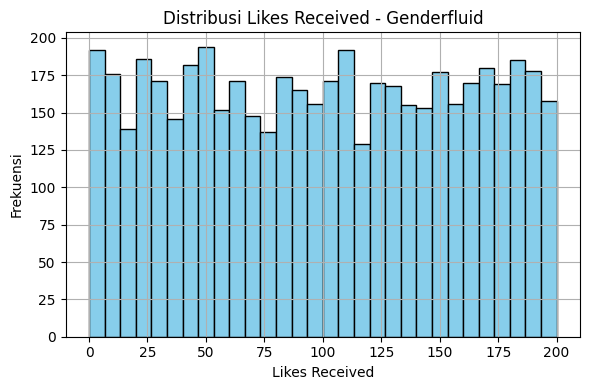

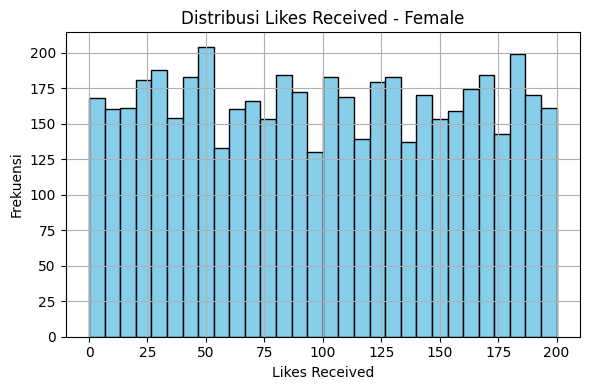

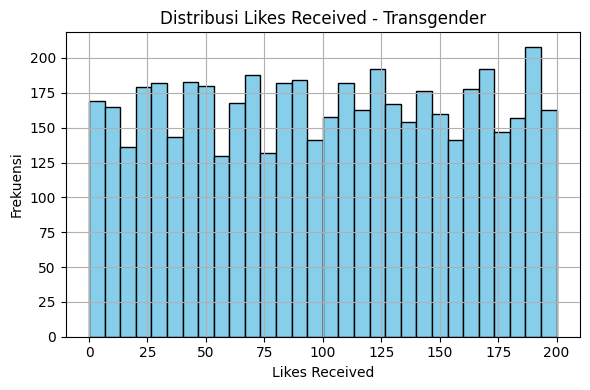

In [6]:
def analyze_likes_received(df_query):
    df_query = df_query.dropna(subset=['gender'])
    df_query = clean_numeric(df_query, 'likes_received')

    print("\n=== Rata-rata Likes Received per Gender ===")
    mean_likes = df_query.groupby('gender')['likes_received'].mean().sort_values(ascending=False)
    print(mean_likes)
    print("\n===  Likes Received per Gender counts ===")
    count_likes = df_query.groupby('gender')['likes_received'].count().sort_values(ascending=False)
    print(count_likes)

    # Histogram per gender (menggunakan sampling)
    genders = df_query['gender'].unique()
    for gender in genders:
        subset = df_query[df_query['gender'] == gender].sample(n=min(5000, len(df_query)), random_state=42)
        plt.figure(figsize=(6, 4))
        plt.hist(subset['likes_received'], bins=30, color='skyblue', edgecolor='black')
        plt.title(f'Distribusi Likes Received - {gender}')
        plt.xlabel('Likes Received')
        plt.ylabel('Frekuensi')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
analyze_likes_received(df_query)

# Insight yang didapat

**Dari analisa yang telah dilakukan diatas dapat disimpulkan** 

1. Rata-rata penerimaan likes di antara semua gender hampir identik, berada di kisaran 98 hingga 100 likes. Secara statistik, perbedaan ini sangat kecil, menunjukkan bahwa secara keseluruhan, tidak ada satu gender pun yang secara signifikan menerima likes lebih banyak daripada yang lain.

2. Meskipun rata-ratanya serupa, pola distribusi likes pada setiap gender menunjukkan fluktuasi dengan beberapa puncak lokal (multimodalitas). Ini mengisyaratkan bahwa ada beberapa sub-kelompok pengguna dengan pola penerimaan likes yang berbeda, meskipun mereka berasal dari gender yang sama.

3. Pola multimodalitas ini membuka peluang besar untuk analisis lanjutan untuk mengidentifikasi faktor-faktor lain, seperti waktu yang dihabiskan, bio yang panjang atau lokasi yang mungkin memengaruhi jumlah likes yang diterima.

# Analisis Multivariat (Binning Time vs Likes)

*Tujuan dilakukannya analisis ini adalah :*

1. Mencari tahu apakah waktu penggunaan pengguna berpengaruh kepada pola multimodalitas yang didapat pada likes setiap gender?
2. Mencari tahu waktu optimal yang dibutuhkan gender untuk mendpaatkan likes maksimal.


C:\Users\user\AppData\Local\Temp\ipykernel_43660\2533882535.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_likes = df_query.groupby(['gender', 'usage_bin'])['likes_received'].mean().reset_index()


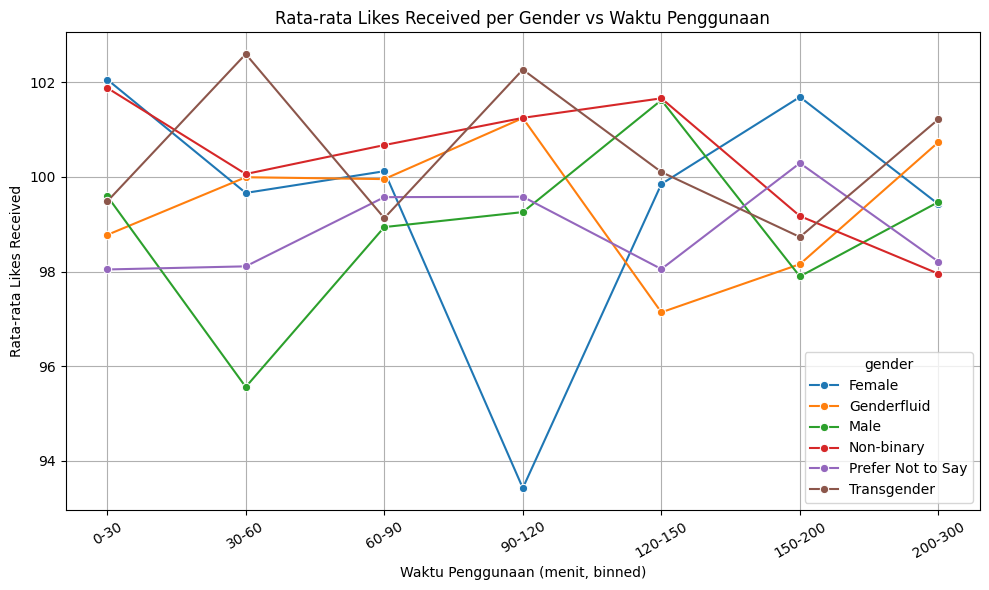

In [7]:
def analyze_usage_vs_likes(df_query):
    df_query = df_query.dropna(subset=['gender'])
    df_query = clean_numeric(df_query, 'likes_received')
    df_query = clean_numeric(df_query, 'app_usage_time_min')

    # Binning waktu penggunaan
    df_query['usage_bin'] = pd.cut(
        df_query['app_usage_time_min'],
        bins=[0, 30, 60, 90, 120, 150, 200, 300, 600],
        labels=['0-30','30-60','60-90','90-120','120-150','150-200','200-300','300-600']
    )

    mean_likes = df_query.groupby(['gender', 'usage_bin'])['likes_received'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=mean_likes, x='usage_bin', y='likes_received', hue='gender', marker='o')
    plt.title('Rata-rata Likes Received per Gender vs Waktu Penggunaan')
    plt.xlabel('Waktu Penggunaan (menit, binned)')
    plt.ylabel('Rata-rata Likes Received')
    plt.xticks(rotation=30)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
analyze_usage_vs_likes(df_query)

# Insight yang didapat dari Analisa Bining times vs likes per gender.
Analisis ini menunjukkan adanya hubungan antara waktu penggunaan aplikasi dengan jumlah likes yang diterima, meskipun rata-rata likes secara keseluruhan tidak menunjukkan perbedaan signifikan antar gender. Setiap gender memiliki pola tren yang unik seiring dengan lamanya waktu penggunaan.

Berikut adalah detail pola tren dan waktu optimal bagi setiap gender:

- Female: Menerima rata-rata likes tertinggi di rentang waktu 0-30 menit, kemudian cenderung menurun seiring bertambahnya waktu penggunaan.

- Genderfluid: Menunjukkan tren rata-rata likes yang menanjak dan mencapai puncaknya di rentang waktu 90-120 menit, sebelum akhirnya menurun.

- Male: Menghadapi fluktuasi di awal, namun mencapai puncak penerimaan likes tertinggi pada rentang 120-150 menit penggunaan.

- Non-Binary: Menerima rata-rata likes tertinggi di 0-30 menit, lalu cenderung naik kembali seiring waktu, tetapi tidak melebihi puncak awal.

- Prefer not to say: Menunjukkan tren paling stabil (stagnant), dengan puncak rata-rata likes di rentang 150-200 menit penggunaan.

- Transgender: Menerima rata-rata likes tertinggi di rentang 30-60 menit, kemudian mengalami fluktuasi tanpa kembali mencapai puncak tersebut.

Pola-pola unik ini mengindikasikan bahwa perilaku pengguna dalam menerima likes dipengaruhi oleh durasi interaksi dengan aplikasi, dan preferensi ini bervariasi antar gender.